In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:

sns.set_theme(style='white')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 56
plt.rcParams["axes.titlesize"] = 56
plt.rcParams["axes.labelsize"] = 52
plt.rcParams["xtick.labelsize"] = 44
plt.rcParams["ytick.labelsize"] = 44
plt.rcParams["legend.fontsize"] = 48
plt.rcParams["figure.titlesize"] = 60


In [7]:
env_to_name = {
	'arcade-v0': "Arcade Rules",
	'binary-v0': "Binary",
	'building-v0': "Building",
	'ddave-v0': "Dangerous Dave",
	'elimination-v0': "Elimination",
	'isaac-v0': "Isaac",
	'loderunner-v0': "Lode Runner",
	'mdungeons-v0': "MiniDungeons",
	'smb-v0': "Super Mario Bros",
	'sokoban-v0': "Sokoban",
	'talakat-v0': "Talakat",
	'zelda-v0': "Zelda"
}

## Lineplot

Plot saved: ./plots\all_envs_fitness_statistics_lineplot.pdf


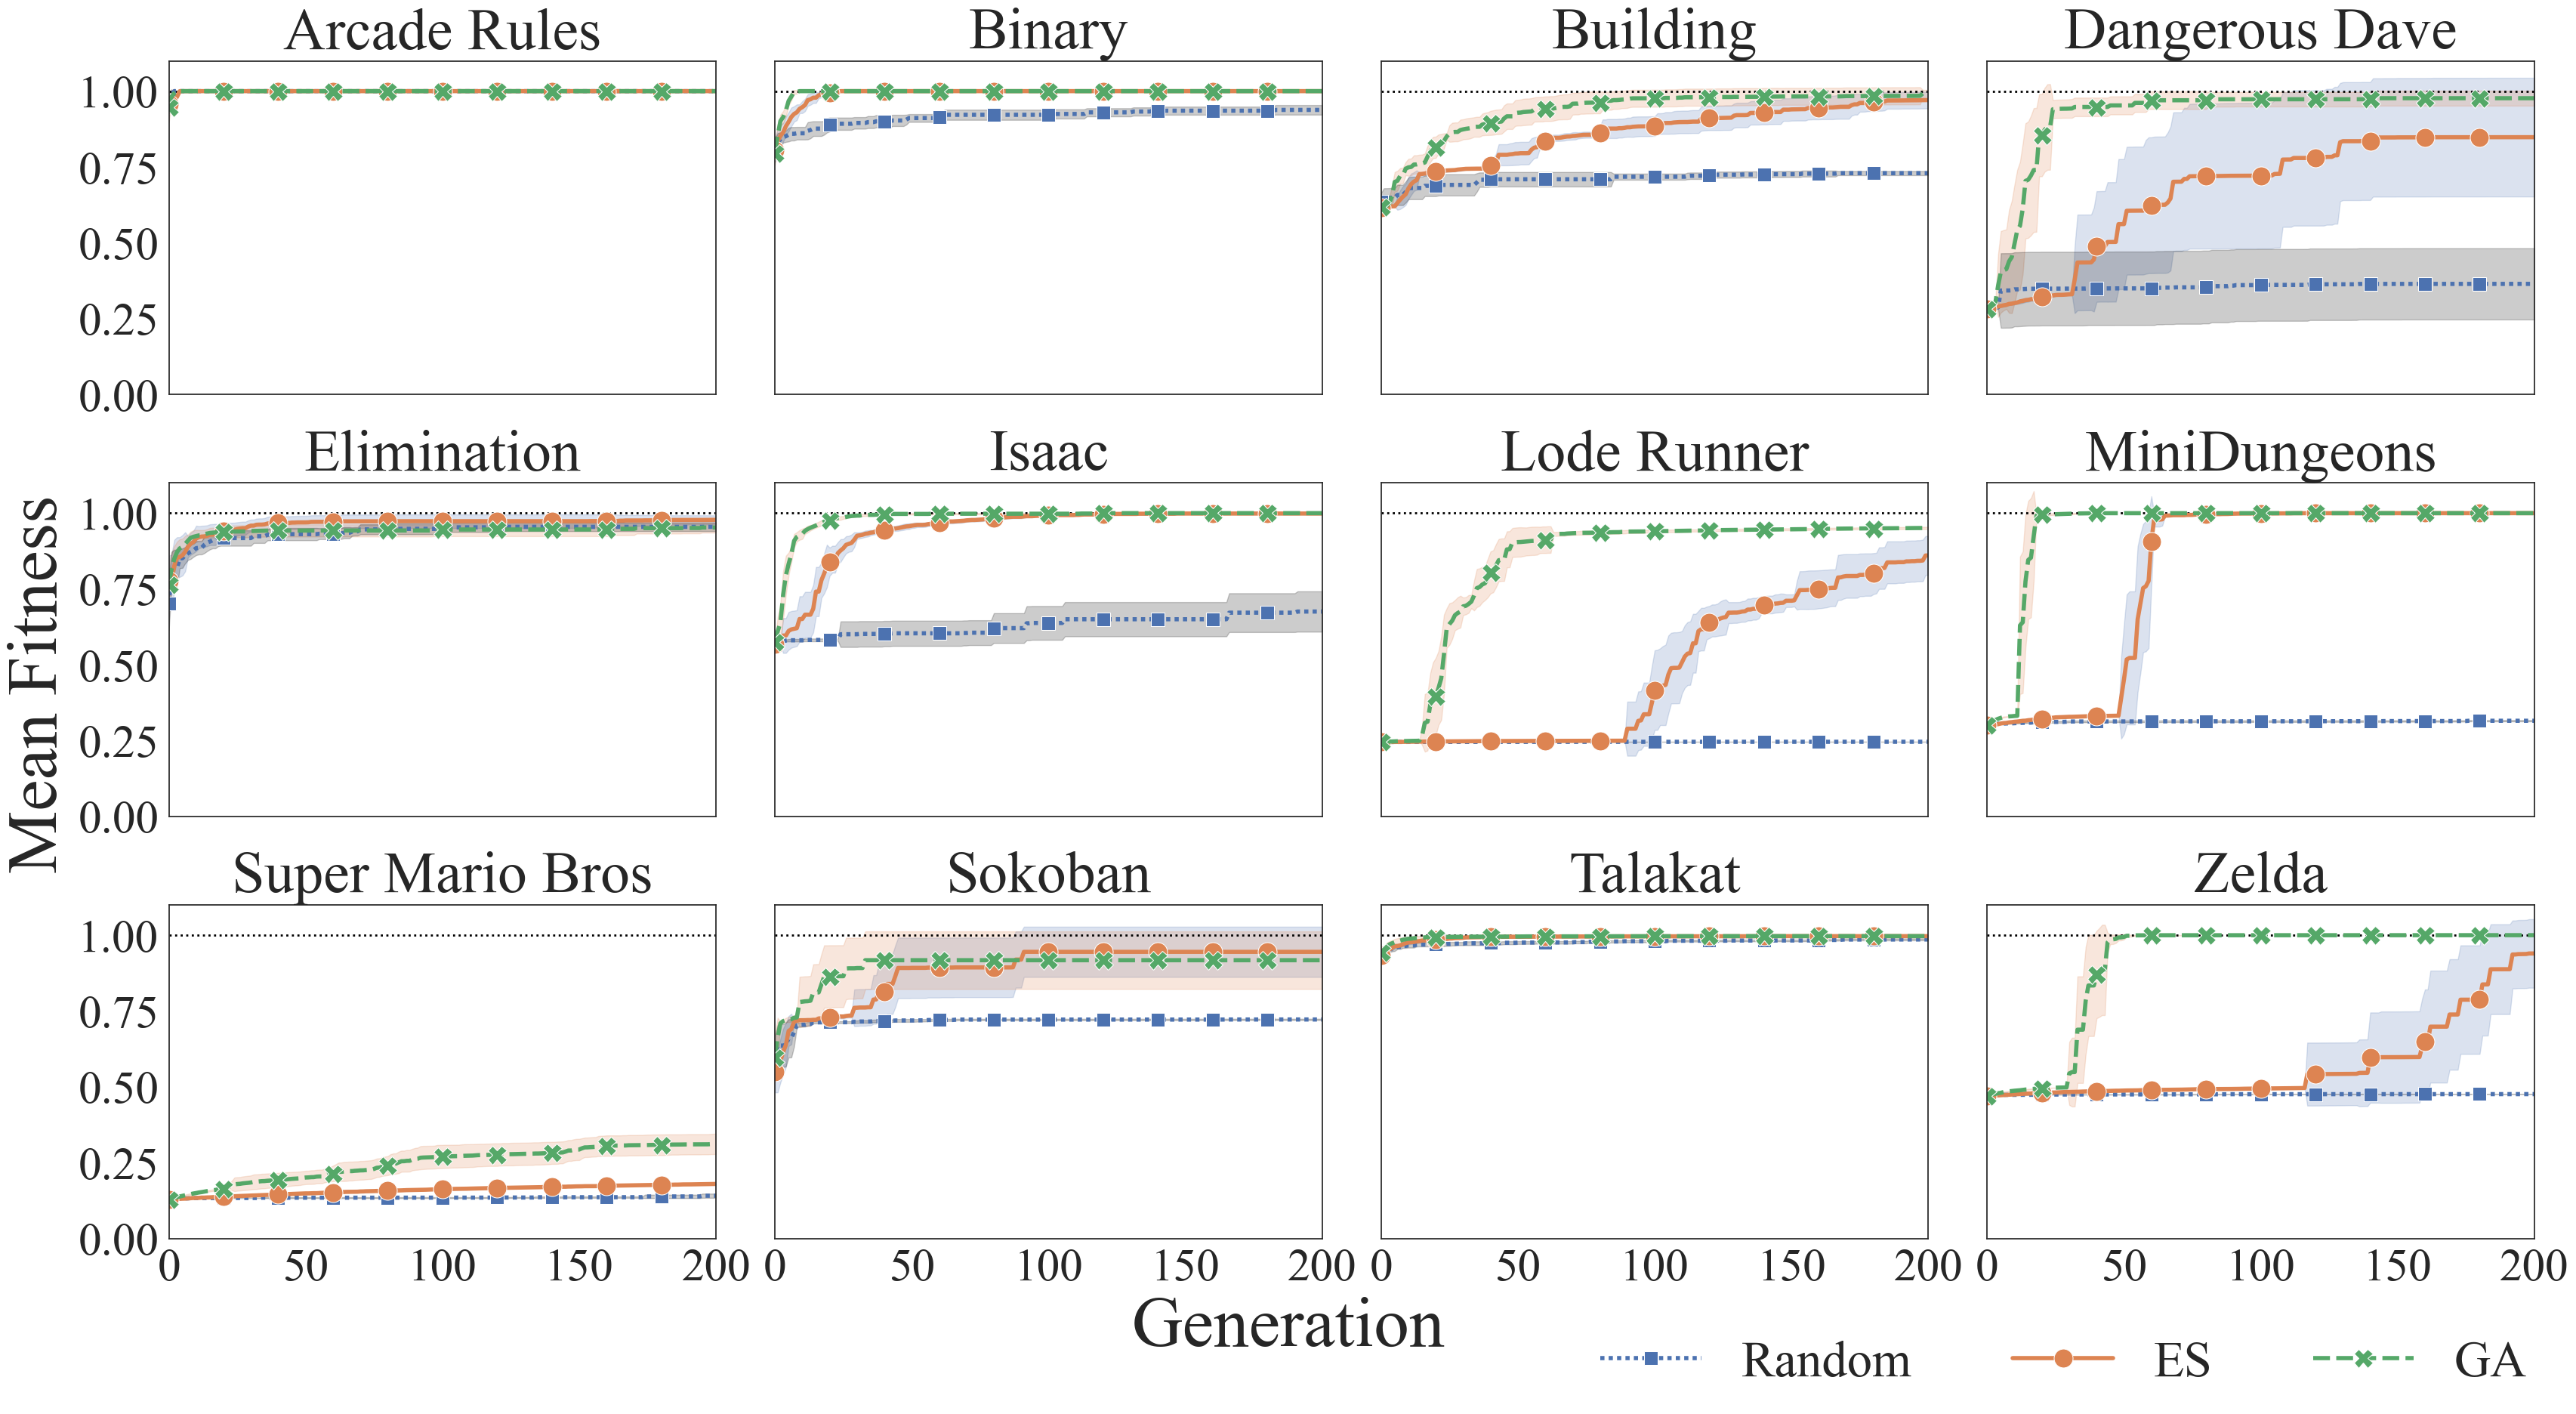

In [8]:
# Load the aggregated statistics from the CSV file
df = pd.read_csv('./results/aggregated_aggr_statistics.csv')
df = df.loc[df['fitness_type'] == 'quality']

# Ensure the output directory exists
os.makedirs('./plots', exist_ok=True)

# Get the unique environments
env_names = df['env_name'].unique()
num_envs = len(env_names)

# Create a 4-row by 3-column grid for subplots
fig, axes = plt.subplots(3, 4, figsize=(34, 18), sharex=True, sharey=True, constrained_layout = True)
axes = axes.flatten()

# Iterate over each environment type and corresponding subplot
for idx, (env_name, env_group) in enumerate(df.groupby('env_name')):
    ax = axes[idx]

    ax.axhline(y=1.0, color='black', linestyle=':', linewidth=2)
    # Plot the fitness property
    sns.lineplot(
        data=env_group,
        x='iter_n',
        y='mean_fitness',
        hue='algorithm',
        hue_order=['random', 'es', 'ga'],
        style='algorithm',
        markers=True,
        markevery=range(0, 200, 20),
        ms=18,
        dashes=True,
        errorbar=None,
        linewidth=4,
        ax=ax
    )

    # Fill between confidence intervals
    for key, grp in env_group.groupby(['algorithm']):
        color = ax.get_lines()[['random', 'es', 'ga'].index(key[0])].get_color()
        ax.fill_between(
            grp['iter_n'],
            grp['lower_ci_fitness'],
            grp['upper_ci_fitness'],
            alpha=0.2,
            color=color
        )

    ax.legend([], [], frameon=False)

    # Plot customization
    ax.set_xticks([0, 50, 100, 150, 200])
    ax.set_yticks([0., 0.25, 0.5, 0.75, 1.0])
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xlabel('Generation' if idx >= 9 else '')  # Label only bottom row
    # ax.set_ylabel('Mean Fitness' if idx % 3 == 0 else '')  # Label only leftmost column
    ax.set_title(env_to_name[env_name])
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 200)

fig.supxlabel('Generation')
fig.supylabel('Mean Fitness')

# Adjust layout
# plt.tight_layout()

# Get existing handles and labels
handles, labels = axes[-1].get_legend_handles_labels()

# Process labels for formatting
for i, label in enumerate(labels):
    if label == 'fitness_type':
        labels[i] = 'Fitness function'
        handles[i].set_linewidth(0.0)  # Hide line for category labels
    if label == 'algorithm':
        labels[i] = 'Algorithm'
        handles[i].set_linewidth(0.0)
    labels[i] = label.title() if label == 'random' else label.upper()

# Remove duplicate labels
unique_labels = dict(zip(labels, handles))

# Add legend inside the main figure
legend = fig.legend(unique_labels.values(), unique_labels.keys(),
                   loc='lower right',
                   bbox_to_anchor=(1, -0.05),
                   frameon=False, ncol=len(unique_labels))

# Increase linewidth of legend handles
for legend_obj in legend.legend_handles:
    legend_obj.set_linewidth(4.0)

# Save the figure
plot_filename = os.path.join('./plots', "all_envs_fitness_statistics_lineplot.pdf")
plt.savefig(plot_filename, bbox_inches='tight')
print(f"Plot saved: {plot_filename}")


## Barplot

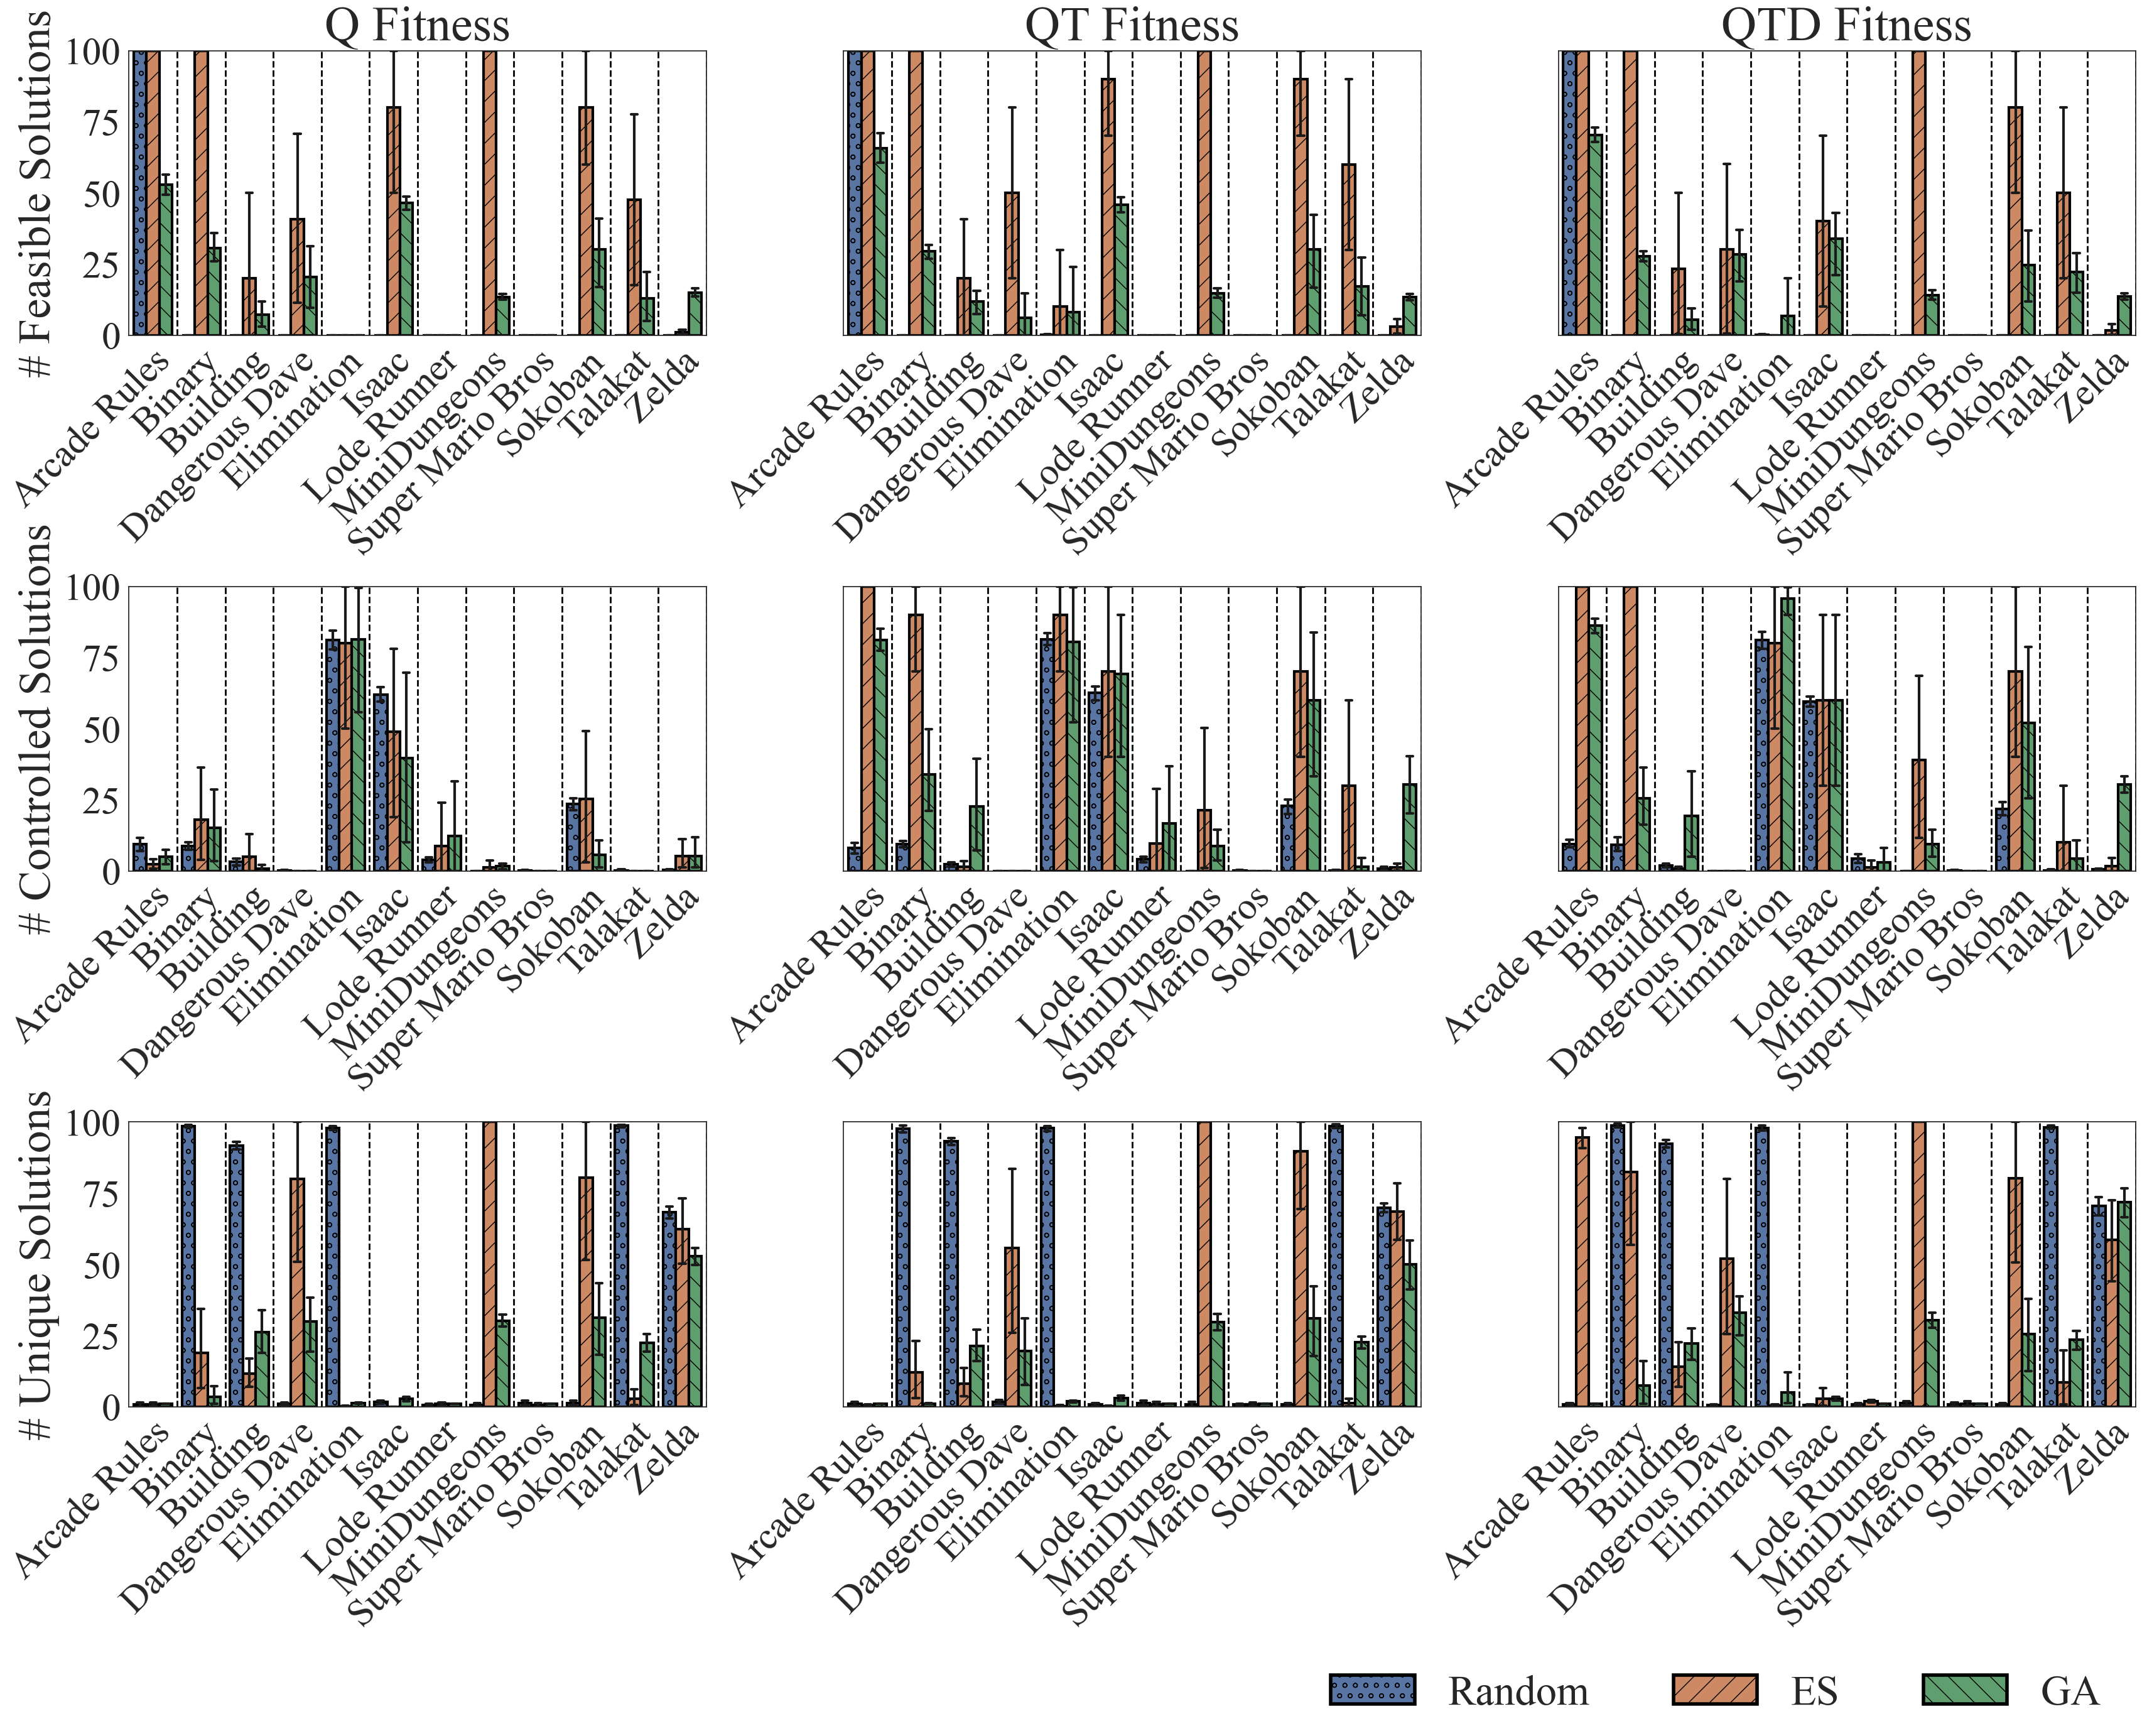

In [10]:
df = pd.read_csv('./results/aggregated_raw_statistics.csv')

fitness_types = df['fitness_type'].unique()
env_names = df['env_name'].unique()

fitness_to_name = {
	    'quality': 'Q Fitness',
	    'quality_control': 'QT Fitness',
	    'quality_control_diversity': 'QTD Fitness'
}

hatches = ['o', '/', '\\']

metrics = ['success_quality', 'success_controlability', 'success_diversity']
labels = ['# Feasible Solutions', '# Controlled Solutions', '# Unique Solutions']
fnames = ['quality', 'controlability', 'diversity']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(34, 26), constrained_layout=True)

for col, fitness in enumerate(fitness_types):
    fitness_data = df[df['fitness_type'] == fitness]
    fitness_data = fitness_data[fitness_data['iter_n'] == 200]

    for row, (y_type, y_label, fname) in enumerate(zip(metrics, labels, fnames)):
        ax = axes[row, col]
        yerr_dict = fitness_data.set_index(['env_name', 'algorithm'])[y_type.replace('mean', 'upper_ci')].to_dict()
        sns.barplot(
            x='env_name', y=y_type, hue='algorithm', hue_order=['random', 'es', 'ga'],
            data=fitness_data, linewidth=3, edgecolor='black', gap=2.0, ax=ax,
	        errorbar=('ci', 95), capsize=0.4, err_kws={'color': 'k', 'linewidth': 3}
        )

        for i, patch in enumerate(ax.patches[:-3]):
            patch.set_hatch(hatches[i // len(env_names)])
        for i, patch in enumerate(ax.patches[-3:]):
            patch.set_hatch(hatches[i])

        if row == 0:
	        ax.set_title(fitness_to_name[fitness])
        else:
	        ax.set_title('')

        # if row == 2:
        ax.set_xticks(range(len(env_to_name.values())))
        ax.set_xticklabels(env_to_name.values(), rotation=45, ha='right', rotation_mode='anchor')
        # else:
	    #     ax.set_xticklabels([])

        if col == 0:
	        ax.set_ylabel(y_label)
	        ax.set_yticks([0, 25, 50, 75, 100])
        else:
	        ax.set_ylabel('')
	        ax.set_yticks([])

        ax.set_xlabel('')
        ax.legend([], [], frameon=False)
        ax.set_ylim(0, 100)

        for i in range(len(env_names)):
            ax.axvline(0.5 + 1.0 * i, 0, 1, linestyle='--', linewidth=2, color='black')

# fig.supxlabel('Environment')

axes = axes.flatten()

# Get existing handles and labels
handles, labels = axes[-1].legend().legend_handles, [t.get_text() for t in axes[-1].legend().texts]

# Process labels for formatting
for i, label in enumerate(labels):
    if label == 'fitness_type':
        labels[i] = 'Fitness function'
        handles[i].set_linewidth(0.0)  # Hide line for category labels
    if label == 'algorithm':
        labels[i] = 'Algorithm'
        handles[i].set_linewidth(0.0)
    labels[i] = label.title() if label == 'random' else label.upper()

# Remove duplicate labels
unique_labels = dict(zip(labels, handles))

# Remove axis legend... again
axes[-1].legend([], [], frameon=False)

# Add legend inside the main figure
legend = fig.legend(unique_labels.values(), unique_labels.keys(),
                   loc='lower right',
                   bbox_to_anchor=(1, -0.07),
                   frameon=False, ncol=len(unique_labels))

# Increase linewidth of legend handles
for legend_obj in legend.legend_handles:
    legend_obj.set_linewidth(4.0)

plot_filename = os.path.join('./plots', "fitness_metrics_subplot.pdf")
fig.savefig(plot_filename, bbox_inches='tight')
plt.show()

plt.close()